# Functions used in HMM Model

In [1]:
from matplotlib import cm, pyplot as plt
import seaborn
from matplotlib.dates import YearLocator, MonthLocator, DayLocator
import pandas as pd
import numpy as np
from datetime import datetime

### Forward algorithm

In [35]:
def forward(tpm, epm, pi, observations):
    """probability that we are in a certain state, given we observed a certain sequence of historical observations
    
    Args:
        tpm (array of arrays) : transition probability matrix
        epm (array of arrays) : emission probability matrix
        pi (array) : initial distribution (probability of being in each state at the start)
        observations (array) : array of emission symbols observed
    
    Returns:
        frwd (int) : probability of being in a certain state
    """
    
    
    """
    Initialization visualization: 
        S1 S2 S3 S4 S5 S6
    T1  .2 .1 .1 .2 .1 .1  (PI)
        * EPM - probability of emitting whatever our first observation is 
    
    """ 
    
    # Create probability matrix forward[N,T] - initialize with 0s
    NUM_STATES = 6
    NUM_OBSERVATIONS = len(observations)
    OBSERVATIONS = observations
    alpha = []
    
    for T in range(NUM_OBSERVATIONS):
        row = []
        
        for N in range(NUM_STATES):
            if OBSERVATIONS[T] == "Increasing":
                row.append(pi[N] * epm[N][0])
            if OBSERVATIONS[T] == "Decreasing":
                row.append(pi[N] * epm[N][1])
            
        alpha.append(row)

    # for each time step from 2 to T
    for time in range(1, len(OBSERVATIONS)):
        curr_time_idx = time
        prev_time_idx = curr_time_idx - 1
        
        for state in range(NUM_STATES):
            prev_paths_sum = 0
            
            for s_prime in range(NUM_STATES):
                # prob of getting to each previous state through all possible paths 
                a = alpha[prev_time_idx][s_prime]
                
                # the transition probability from previous S to current S
                b = tpm[s_prime][state]
                
                # the emission probability of emitting observation at current S
                if OBSERVATIONS[time] == "Increasing":
                    c = epm[state][0]
                if OBSERVATIONS[time] == "Decreasing":
                    c = epm[state][1]
                    
                prev_paths_sum += a * b * c

            alpha[curr_time_idx][state] = prev_paths_sum

    return alpha

### Backward algorithm

In [3]:
def backward(tpm, epm, pi, observations):
    """probability that we will see a certain sequence of future observations, given we are in a certain state
    
    Args:
        tpm (array of arrays) : transition probability matrix
        epm (array of arrays) : emission probability matrix
        pi () : initial distribution (probability of being in each state at the start)
        observations (array) : array of emission symbols observed
    
    Returns:
        backwd (int) : probability of being in a certain state
    """
    # Create probability matrix forward[N,T] - initialize with 0s
    NUM_STATES = 6
    NUM_OBSERVATIONS = len(observations)
    OBSERVATIONS = observations
    beta = []
    
    for T in range(NUM_OBSERVATIONS):
        row = []
        
        for N in range(NUM_STATES):
            row.append(1.0)
        
        beta.append(row)
    
    # recursion
    # for each time step from T-1 to 1 (end is exclusive)
    for time in range(len(OBSERVATIONS) - 2, -1, -1):
        
        for state in range(NUM_STATES):
            next_paths_sum = 0
            
            for s_prime in range(NUM_STATES):
                # prob of getting to each next state through all possible paths 
                a = beta[time+1][s_prime]
                
                # the transition probability from next S to current S
                b = tpm[state][s_prime]
                
                # the emission probability of emitting observation at next S
                if OBSERVATIONS[time] == "Increasing":
                    c = epm[s_prime][0]
                if OBSERVATIONS[time] == "Decreasing":
                    c = epm[s_prime][1]
                    
                next_paths_sum += a * b *c

            beta[time][state] = next_paths_sum

    return beta

### Baum-Welch algorithm

In [33]:
def check_convergence(old_matrix, new_matrix):
    """returns true if matricies have converged (aka are the same), false otherwise
    
    Args:
        old_matrix (array of arrays) : old matrix
        new_matrix (array of arrays) : new matrix
        
    Returns:
        converge (boolean) : represents whether the given matricies have converged or not
        
    """
    converge = True
    for col in range(len(old_matrix)):
        for row in range(len(old_matrix[col])):
            if old_matrix[col][row] != new_matrix[col][row]:
                converge = False
    
    return converge

In [34]:

def baum_welch(tpm, epm, pi, emissions):
    """probability of initial parameters that generated emissions data
    
    Args:
        tpm (array of arrays) : transition probability matrix
        epm (array of arrays) : emission probability matrix
        pi (array) : initial distribution (probability of being in each state at the start)
        observations (array) : array of emission symbols observed
    
    Returns:
    
    """
    # transition probabilities
    A = np.zeros((6, 6))
    # observation probabilities
    B = np.ones((len(emissions) + 1, 2))

    
    # num state
    M = len(tpm)
    # time steps
    T = len(emissions)
    xi = np.zeros((M, M, T - 1))
    
    # iterate until convergence
    # while (check_convergence(tpm, A) == False and check_convergence(epm, B) == False):  
    for i in range(10):
        alpha = forward(tpm, epm, pi, emissions)
        beta = backward(tpm, epm, pi, emissions)
        
        # E STEP

        for time in range(T - 1):
            
            # get emissions index
            if emissions[time+1] == "Increasing":
                idx = 0
            if emissions[time+1] == "Decreasing":
                idx = 1
                
            # calculate denominator for xi at given time
            const_a = np.dot(alpha[time][:], tpm)
            temp_b = []
            for state in epm:
                temp_b.append(state[idx])
            const_b = const_a * temp_b
            const_c = np.dot(const_b, beta[time + 1][:])
                
            denom = const_c

            for state_i in range(M):
                # calculate numerator for xi at  given time and state_i
                const_forward = alpha[time][state_i]
                const_transition = tpm[state_i][:]
                temp_b = []
                for state in epm:
                    temp_b.append(state[idx])  
                const_emission = temp_b
                const_backward = beta[time+1][:]
                
                temp_x = np.multiply(const_forward, const_transition)
                numerator = temp_x * const_emission * const_backward
                
                xi[state_i, :, time] = numerator / denom
                    
        # calculate gamma from xi            
        gamma = np.sum(xi, axis=1)
        
        # M STEP
        
        # update alpha - a = np.sum(xi, 2) / np.sum(gamma, axis=1).reshape((-1, 1))
        
        alpha_numerator = 0
        for time in range(T - 1):
            alpha_numerator += xi[:, :, time]
        
        alpha_denominator = 0
        for time in range(T - 1):
            alpha_denominator += gamma[:, time]
        
        tpm = alpha_numerator / alpha_denominator.reshape((-1, 1))
        
        
        # Add additional T'th element in gamma
        gamma = np.hstack((gamma, np.sum(xi[:, :, T - 2], axis=0).reshape((-1, 1))))

        
        # update beta

        increasing_idx = 0     # tracked observation variable
        decreasing_idx = 1
        
        for state in range(6):

            numerator_increasing = 0
            numerator_decreasing = 0
            denom = 0

            for time in range(len(emissions)):

                if emissions[time] == "Increasing":
                    numerator_increasing += gamma[state, time]
                    
                if emissions[time] == "Decreasing":
                    numerator_decreasing += gamma[state, time]

                denom += gamma[state, time]

            epm[state][increasing_idx] = numerator_increasing / denom
            epm[state][decreasing_idx] = numerator_decreasing / denom
                
    #print("gamma\n", gamma)
    #print('xi\n', xi)
    return tpm, epm

### Viterbi algorithm

In [38]:
def viterbi(tpm, epm, pi, observations):
    """Given a sequence of observed values, provide us with the sequence of states 
        the HMM most likely has been in to generate such values sequence
    
    Args:
        tpm (array of arrays) : transition probability matrix
        epm (array of arrays) : emission probability matrix
        pi (array) : initial distribution (probability of being in each state at the start)
        observations (array) : array of emission symbols observed
    
    Returns: array of the most probable state-sequence based on the observations and HMM model
    """
    
    num_states = 6
    states_names = ['very_low','low','moderate_low','moderate_high','high','very_high' ]
    
    # create path probability matrix num observations by num states
    # initialize to 0
    path_probability_matrix = np.zeros((len(observations), num_states ))

    #create a path backpointer matrix backpointer[N, L + 2] to save indexes of states
    # initialize to 0
    path_backpointer_maxtrix = np.zeros((len(observations), num_states ))
    
    max_states = np.zeros(len(observations))
    final_path=[]
    final_path = ['starting' for i in range(len(observations))]

    
    #grab first observation to determine which EPM index to use
    if observations[0] == "Increasing":
        obs_index = 0
    else:
        obs_index = 1
        
    # update first row of path_probability_matrix matrix
    # first row = probability of starting in each state * prob of seeing observation in that state
    for s in range(num_states):
        path_probability_matrix[0][s] = pi[s] * epm[s][obs_index]  
    
    for t in range(1, len(observations)):
        for s in range(num_states):
            
            backpointer_probabilities = []
            probabilities = []
            
            for s_prime in range(num_states):
                
                # prob of getting to each previous state through all possible paths
                a = path_probability_matrix[t-1][s_prime]
                
                # the transition probability from previous S to current S
                b = tpm[s_prime][s]
                
                backpointer_prob = a * b
                backpointer_probabilities.append(backpointer_prob)
                
                # the emission probability of emitting observation at current S
                if observations[t-1] == "Increasing":
                    c = epm[s][0]
                if observations[t-1] == "Decreasing":
                    c = epm[s][1]
                    
                path_probability = a * b * c
                probabilities.append(path_probability)
        
            # update path_probability_matrix[t,s] to MAX probability of most prob state for previous observation
            path_probability_matrix[t][s] = max(probabilities)

            # update back_pointer[t, s] to be argMax calculated of previous obs for given observation
            path_backpointer_maxtrix[t][s] = np.argmax(backpointer_probabilities)
            
    #grab end state probability and index 
    end_state_probability = max(path_probability_matrix[-1:])
    end_state_index = np.argmax(path_probability_matrix[-1:])

    #go backwards through backpointer
    final_path[len(observations)-1] = end_state_index

    for i in range(len(observations)-1, -1, -1):
        final_path_state = path_backpointer_maxtrix[i][end_state_index]
        final_path[i] = final_path_state
        end_state_index = int(final_path_state)

    return(final_path)

### Data cleaning and set up

In [7]:
def get_stock_data(file_name):
    """scrapes and cleans the data from the given file and creates a dataframe
    
    Args:
        file_name (string) : name of file
    
    Returns:
        df_stock (dataframe) : dataframe containing stock info scraped from file
    """
    df_stock = pd.DataFrame()
    file = open(file_name)
    txt = file.read()
    file.close()
    
    # split text into list, split by new line character
    txt = txt.split('\n')
    # get column titles
    columns = txt[0].split(',')

    for line in txt[1:]:
        temp_dict = dict()
        line = line.strip()
        line_list = line.split(',')

        # if row does not have sufficient column information, pass over
        if len(columns) != len(line_list):
            continue

        # add column's corresponding values to a temporary dictionary   
        for idx in range(len(columns)):
            column_name = columns[idx]
            
            # change all date column info to datetime object
            if column_name == 'Date':
                temp_dict[column_name] = datetime.strptime(line_list[idx], '%Y-%m-%d')
            else:
                temp_dict[column_name] = line_list[idx]

        # append dictionary to dataframe                                                  
        df_stock = df_stock.append(temp_dict, ignore_index=True)
    
    return df_stock

In [8]:
def get_emission(stock_dataframe):
    """ Calculates the one day difference between stock closing value (today - yesterday)
        and determines emission symbol based on if stock price increased or decreased from previous day
    
    Args:
        stock_dataframe (dataframe) : dataframe containing stock info(close value, date, high, low, open, etc.)
    
    Returns:
        one_day_dif_df(dataframe) : dataframe containing the difference from the previous day's stock value
                                    as well as the related emission symbol (Increasing or Decreasing)
    """
    
    # Subset the initial DF to obtain only relevant columns
    one_day_dif_df = stock_dataframe.copy()
    one_day_dif_df = one_day_dif_df[['Date','Close']]
    
    # Convert CV to numeric for calculations
    one_day_dif_df['Close'] = pd.to_numeric(one_day_dif_df['Close'])
    one_day_dif_df['Yesterday Close'] = one_day_dif_df['Close'].shift()
    
    # Calculate the stock's closing price difference from the previous day
    one_day_dif_df['Close Value Difference'] = round((one_day_dif_df['Close'] - one_day_dif_df['Yesterday Close']),2)
    
    one_day_dif_df['Emission'] = 'NaN'
    row_indexes_inc = one_day_dif_df[one_day_dif_df['Close Value Difference']>=0].index
    row_indexes_dec = one_day_dif_df[one_day_dif_df['Close Value Difference']<0].index
    
    one_day_dif_df.loc[row_indexes_inc,'Emission']='Increasing'
    one_day_dif_df.loc[row_indexes_dec,'Emission']='Decreasing'
    #one_day_dif_df['Emission'] = ['Increasing' if x > 0 else 'Decreasing' for x in one_day_dif_df['Close Value Difference']]
    
    return one_day_dif_df

In [9]:
def create_TPM(n):
    """creates transition probability matrix and initializes to equal random probabilities
    
    Args:
        n (int) : number of possible states
        
    Returns:
        tpm (array of arrays) : n by n transition probability matrix
                                    s1 s2 s3 s4 s5 s6
                                s1
                                s2
                                s3
                                s4
                                s5
                                s6
    """
    tpm = []
    
    for idx in range(n):
        rand_prob = round(1 / n, 2)
        row = []
        
        for idx in range(n):
            row.append(rand_prob)
            
        tpm.append(row)
    return tpm

In [10]:
def create_EPM(n, m):
    """creates emissions probability matrix and initializes to equal random probabilities
    
    Args:
        n (int) : number of possible states
        m (int) : number of possible observation symbols
        
    Returns:
        epm (array of arrays) : n by m emission probability matrix
                                    I  D
                                s1
                                s2
                                s3
                                s4
                                s5
                                s6
    """
    
    epm = []
    
    for idx in range(n):
        rand_prob = round(1 / m, 2)
        row = []
        
        for idx in range(m):
            row.append(rand_prob)
            
        epm.append(row)
        
    return epm

In [11]:
### Graphing Viterbi Output

In [71]:

# add the outcome of hidden states to the stock dataframe
# states_path = viterbi(tpm, epm, pi, emissions)

def add_hidden_states_to_df(original_stock_df, states_path):
    """ Add the calcuated hidden state sequence to the original stock dataframe
    
    Args:
        original_stock_df (dataframe): original dataframe with stock information used in HMM
        states_path (array): calculated state sequence using HMM
    
    Returns: updated stock DataFrame including the probable state-sequence based on the observations and HMM model
    """

    states_path_df = pd.DataFrame(states_path,columns=['States_Path'])
    states_path_df.loc[-1] = 'starting state' # add starting state because it is NaN row
    states_path_df.index = states_path_df.index + 1  # shifting index
    states_path_df = states_path_df.sort_index()
    states_path_df.T

    updated_stock_df = original_stock_df.copy()

    updated_stock_df['Hidden_State'] = states_path_df['States_Path']
    
    return(updated_stock_df)

In [77]:
def graph_hidden_states(updated_stock_df):
    """ Graph the hidden states by date and close price
    
    Args:
        updated_stock_df (dataframe): dataframe with stock information used in HMM and determined hidden states
    
    Returns: Nothing, but graphs the input DF.
    """

    dates = updated_stock_df["Date"]
    close_v = updated_stock_df["Close"]
    states = updated_stock_df["Hidden_State"]

    fig, axs = plt.subplots(len(updated_stock_df.Hidden_State.unique()), sharex=True, sharey=True)
    colours = cm.rainbow(np.linspace(0, 1, (len(updated_stock_df.Hidden_State.unique()))))
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        # Use fancy indexing to plot data in each state.
        mask = states == i
        ax.plot_date(dates[mask], close_v[mask], ".-", c=colour)
        ax.set_title("{0}th hidden state".format(i))
        ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)

    # set axis
    plt.xlim(dates[0], dates[len(dates)-1])

    # set y-axis
    plt.ylim(np.amin(close_v) - 20, np.amax(close_v) + 10)

    # plt.xlim(1, 10)
    fig.set_size_inches(15, 15)
    seaborn.set()
    plt.show(), states_path

In [14]:
# Biogen

In [66]:
file_name = 'biib.us.txt'
df_biib_stock = get_stock_data(file_name)
df_biib_stock = df_biib_stock[-30:]
df_biib_stock = df_biib_stock.reset_index()
df_biib_stock


,index,Close,Date,High,Low,Open,OpenInt,Volume
0,6556,316.17,2017-10-02,317.13,313.12,315.19,0,1669719
1,6557,317.39,2017-10-03,317.8,313.91,317.11,0,850783
2,6558,314.92,2017-10-04,316.55,306,313.57,0,1067637
3,6559,326.74,2017-10-05,330.98,320.276,320.72,0,2159738
4,6560,327.48,2017-10-06,328.5,324.6,325.21,0,1023638
5,6561,329.01,2017-10-09,332.24,326.325,327.46,0,902443
6,6562,332.81,2017-10-10,332.87,328.25,328.55,0,1001224
7,6563,333.19,2017-10-11,333.33,329.27,332.12,0,937951
8,6564,333.31,2017-10-12,334.32,330.04,332.93,0,1131332
9,6565,337.64,2017-10-13,338.94,332.07,333.26,0,1358790


In [82]:
# Get data and initialize
df_emission = get_emission(df_biib_stock)
emission = df_emission['Emission'][1:]

emission_list = emission.tolist()
print(emission_list)
print(["Increasing", "Increasing", "Increasing", "Decreasing", "Decreasing"])

tpm = [[0.2, 0.1, 0.3, 0.1, 0.2, 0.1],
       [0.3, 0.1, 0.1, 0.2, 0.3, 0],
       [0.1, 0.1, 0.1, 0.3, 0.2, 0.2],
       [0.4, 0.1, 0.1, 0.1, 0.1, 0.2],
       [0.3, 0.2, 0.1, 0.1, 0.1, 0.2],
       [0.2, 0.2, 0.2, 0.1, 0.1, 0.2]]

#tpm = create_TPM(6)

epm = create_EPM(6, 2)
NUM_STATES = 6

pi = [.2, .1, .1, .2, .1, .1]

['Increasing', 'Decreasing', 'Increasing', 'Increasing', 'Increasing', 'Increasing', 'Increasing', 'Increasing', 'Increasing', 'Decreasing', 'Increasing', 'Increasing', 'Decreasing', 'Decreasing', 'Decreasing', 'Decreasing', 'Decreasing', 'Decreasing', 'Increasing', 'Increasing', 'Decreasing', 'Increasing', 'Decreasing', 'Increasing', 'Increasing', 'Decreasing', 'Decreasing', 'Decreasing', 'Increasing']
['Increasing', 'Increasing', 'Increasing', 'Decreasing', 'Decreasing']


In [83]:
tpm, epm = baum_welch(tpm, epm, pi, emission_list)

In [84]:
states_path = viterbi(tpm, epm, pi, emission_list)

In [85]:
updated_stock_df = add_hidden_states_to_df(df_emission, states_path)

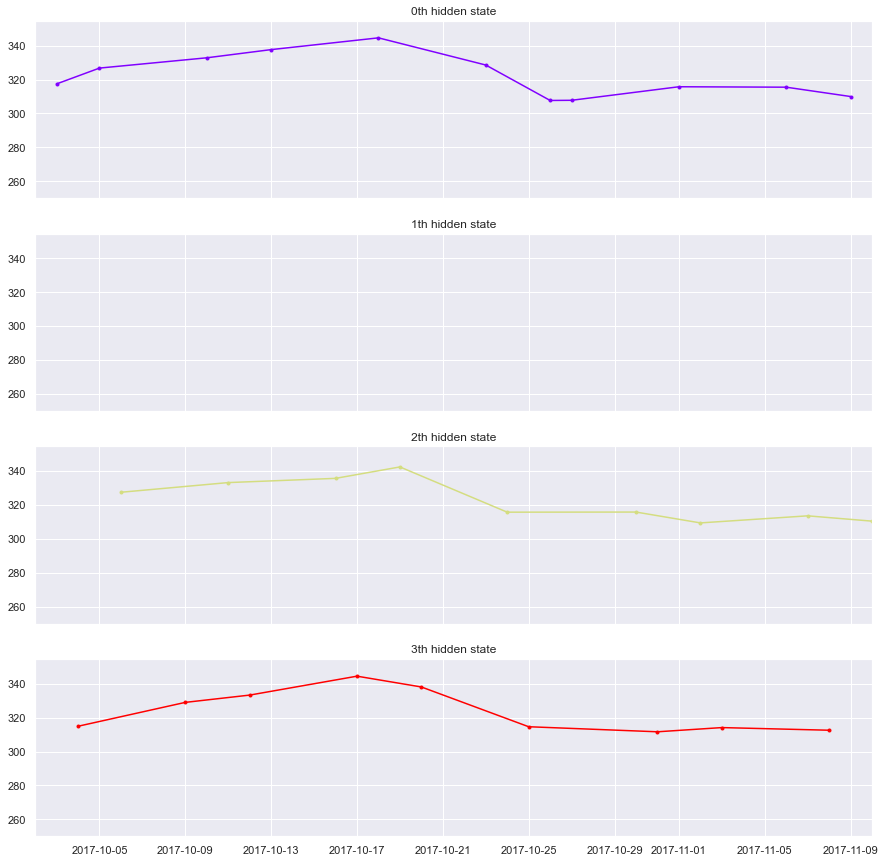

In [86]:
graph_hidden_states(updated_stock_df)